# Generating subglacial topography with Variational Auto Encoder

The keras VAE example at [link](https://keras.io/examples/generative/vae/) is used as a template to create the autoencoder.
To learn about VAEs use this [link](https://towardsdatascience.com/understanding-variational-autoencoders-vaes-f70510919f73)

Briefly (as per ChatGPT), Variational Autoencoders (VAEs) are like artists who learn to paint pictures. They have a special way of turning a photo into a smaller, simpler code (like a summary of the picture). This code can then be used to recreate the original photo. VAEs add a bit of randomness to their process, making each painting a little different. They learn to make these unique pictures by practicing until they're good at capturing the essence of the photos. So, they're not just copying, but creating new, similar pictures with a touch of creativity. 

Import required libraries

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D, Flatten, Reshape, Lambda, Layer, Conv2DTranspose
from tensorflow.keras.models import Model
from tensorflow.keras.losses import binary_crossentropy, mse
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
import matplotlib.pyplot as plt
import os
from mpl_toolkits.axes_grid1 import make_axes_locatable
from scipy.signal import periodogram
import gstools as gs

Load the dataset prepared by Andrew which has been scaled and organized into 1564 square sections. The files are currently in [gdrive](https://drive.google.com/file/d/14_BeoL-7z6S1gZy9QzaX8XNQ5VraQ_o9/view?usp=sharing). Github has a 100MB upload limit currently. The link only works with a LDEO google signin. Download this file, unzip and paste the contents in the `data` folder

In [2]:
data = np.load('data/thw_image_stack.npy')

In [3]:
data.shape

(1564, 512, 512, 1)

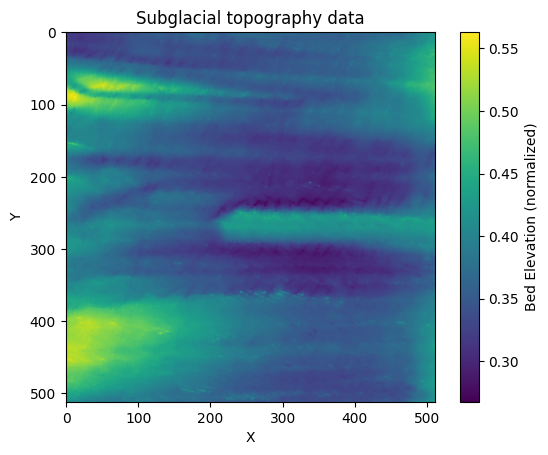

In [4]:
plt.imshow(data[15])
plt.title('Subglacial topography data')
plt.xlabel('X')
plt.ylabel('Y')
color_bar = plt.colorbar()
color_bar.set_label('Bed Elevation (normalized)')

# VAE

In [5]:
class Sampling(Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.random.normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon


Encoder of the VAE

In [6]:
latent_dim = 64 # number of latent dimensions, this is a tunable parameter

encoder_inputs = Input(shape=(512, 512, 1))
x = Conv2D(32, 3, activation="relu", strides=2, padding="same")(encoder_inputs)
x = Conv2D(64, 3, activation="relu", strides=2, padding="same")(x)
x = Conv2D(64, 3, activation="relu", strides=2, padding="same")(x)
x = Conv2D(64, 3, activation="relu", strides=2, padding="same")(x)
x = Conv2D(64, 3, activation="relu", strides=2, padding="same")(x)
x = Conv2D(64, 3, activation="relu", strides=2, padding="same")(x)
x = Conv2D(64, 3, activation="relu", strides=2, padding="same")(x)
x = Conv2D(64, 3, activation="relu", strides=2, padding="same")(x)
shape_x = x.shape[1:]
x = Flatten()(x)

x = Dense(latent_dim, activation="relu")(x)
z_mean = Dense(latent_dim, name="z_mean")(x)
z_log_var = Dense(latent_dim, name="z_log_var")(x)
z = Sampling()([z_mean, z_log_var])
encoder = Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 512, 512, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 32  320         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 128, 128, 64  18496       ['conv2d[0][0]']                 
                                )                                                           

Decoder of the VAE

In [7]:
latent_inputs = Input(shape=(latent_dim,))
x = Dense(shape_x[0] * shape_x[1] * shape_x[2], activation="relu")(latent_inputs)
x = Reshape(shape_x)(x)
x = Conv2DTranspose(64, 3, activation="relu", strides=2, padding="same")(x)
x = Conv2DTranspose(64, 3, activation="relu", strides=2, padding="same")(x)
x = Conv2DTranspose(64, 3, activation="relu", strides=2, padding="same")(x)
x = Conv2DTranspose(64, 3, activation="relu", strides=2, padding="same")(x)
x = Conv2DTranspose(64, 3, activation="relu", strides=2, padding="same")(x)
x = Conv2DTranspose(64, 3, activation="relu", strides=2, padding="same")(x)
x = Conv2DTranspose(64, 3, activation="relu", strides=2, padding="same")(x)
x = Conv2DTranspose(32, 3, activation="relu", strides=2, padding="same")(x)
decoder_outputs = Conv2DTranspose(1, 3, activation="linear", padding="same")(x)
decoder = Model(latent_inputs, decoder_outputs, name="decoder")
decoder.summary()


Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 64)]              0         
                                                                 
 dense_1 (Dense)             (None, 256)               16640     
                                                                 
 reshape (Reshape)           (None, 2, 2, 64)          0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 4, 4, 64)         36928     
 nspose)                                                         
                                                                 
 conv2d_transpose_1 (Conv2DT  (None, 8, 8, 64)         36928     
 ranspose)                                                       
                                                                 
 conv2d_transpose_2 (Conv2DT  (None, 16, 16, 64)       3692

In [8]:
class VAE(tf.keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super().__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = tf.keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = tf.keras.metrics.Mean(
            name="reconstruction_loss"
        )
        self.kl_loss_tracker = tf.keras.metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def train_step(self, data):
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)
            reconstruction_loss = tf.reduce_mean(
                tf.reduce_sum(
                    tf.keras.losses.mean_squared_error(data, reconstruction),
                    axis=(1, 2),
                )
            )
            kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
            total_loss = reconstruction_loss + kl_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }


Create VAE

In [9]:
vae = VAE(encoder, decoder)
vae.compile(optimizer=tf.keras.optimizers.Adam())

Reduce learning rate if a plateau is reached during training

In [10]:
reduce_lr = ReduceLROnPlateau(monitor='loss', factor=0.2,
                              patience=50, min_lr=0.0001)

Train VAE

In [12]:
epochs = 400
history = vae.fit(data, epochs=epochs, batch_size=8, shuffle=True,  callbacks=[reduce_lr])

Epoch 1/400
196/196 [==============================] - 23s 117ms/step - loss: 3020.8648 - reconstruction_loss: 2944.8362 - kl_loss: 7.2772 - lr: 0.0010
Epoch 2/400
196/196 [==============================] - 22s 112ms/step - loss: 2008.0040 - reconstruction_loss: 1567.9379 - kl_loss: 52.0713 - lr: 0.0010
Epoch 3/400
196/196 [==============================] - 23s 116ms/step - loss: 966.7533 - reconstruction_loss: 842.3541 - kl_loss: 58.9879 - lr: 0.0010
Epoch 4/400
196/196 [==============================] - 22s 114ms/step - loss: 827.9218 - reconstruction_loss: 723.9164 - kl_loss: 61.3606 - lr: 0.0010
Epoch 5/400
196/196 [==============================] - 22s 114ms/step - loss: 735.2240 - reconstruction_loss: 627.4139 - kl_loss: 63.3087 - lr: 0.0010
Epoch 6/400
196/196 [==============================] - 23s 118ms/step - loss: 633.4387 - reconstruction_loss: 551.1290 - kl_loss: 65.4072 - lr: 0.0010
Epoch 7/400
196/196 [==============================] - 23s 117ms/step - loss: 591.0536 - re

Save VAE (This hasn't been tested)

In [13]:
vae.get_layer('encoder').save_weights('encoder_weights.h5')
vae.get_layer('decoder').save_weights('decoder_weights.h5')


#Since both encoder and decoder are treated as models, you also need to save their architecture defined via instantiated VAE model
vae.get_layer('encoder').save('encoder_arch')
vae.get_layer('decoder').save('decoder_arch')

INFO:tensorflow:Assets written to: encoder_arch\assets


INFO:tensorflow:Assets written to: encoder_arch\assets


INFO:tensorflow:Assets written to: decoder_arch\assets


INFO:tensorflow:Assets written to: decoder_arch\assets


Plot loss to check for convergence

In [14]:
total_loss = history.history['loss']
reconstruction_loss = history.history['reconstruction_loss']
kl_loss = history.history["kl_loss"]

Text(0, 0.5, 'loss')

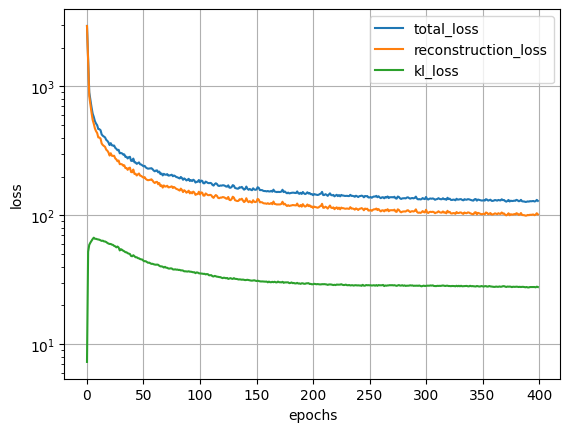

In [15]:
plt.semilogy(total_loss, label = 'total_loss')
plt.semilogy(reconstruction_loss, label = 'reconstruction_loss')
plt.semilogy(kl_loss, label = 'kl_loss')
plt.grid()
plt.legend()
plt.xlabel('epochs')
plt.ylabel('loss')

Generate random images by sampling the latent space

1/1 [==============================] - 1s 1s/step


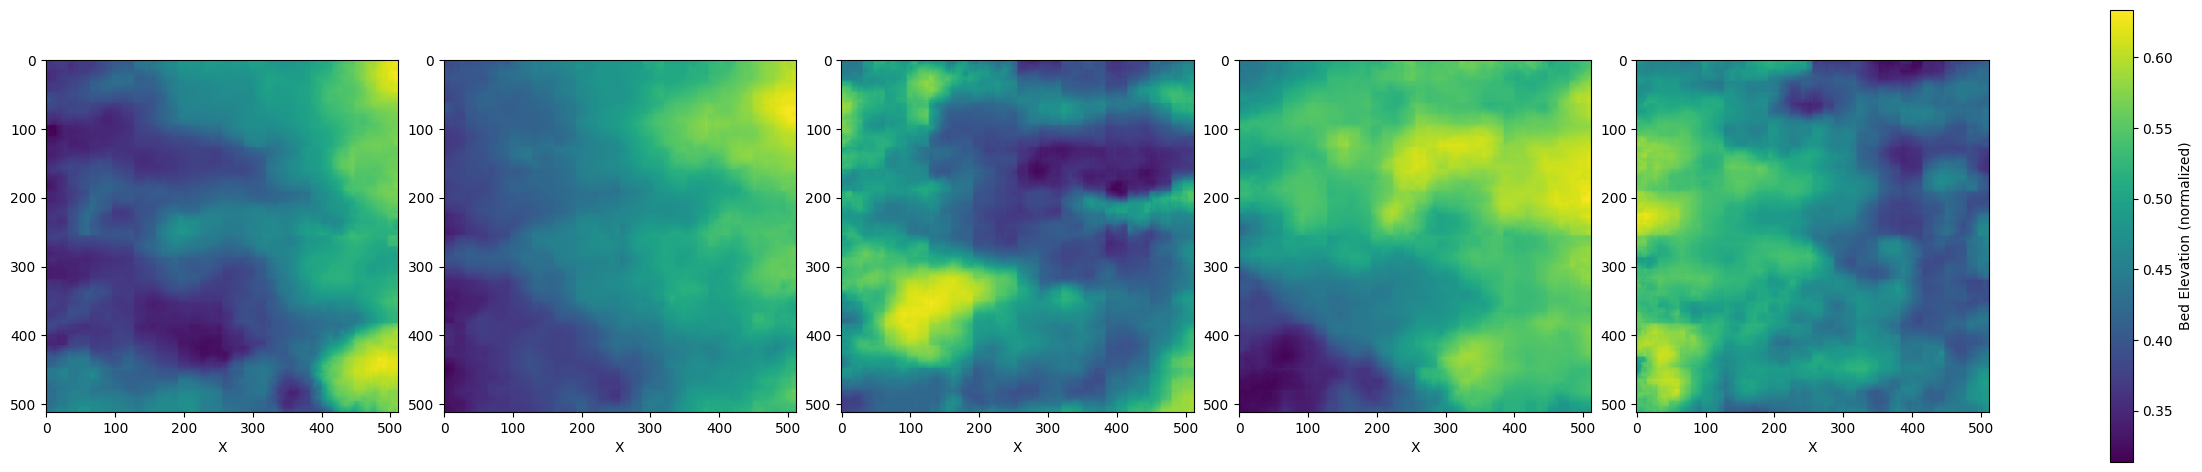

In [16]:
def generate_images(decoder, n=5):
    # Sample from the latent space
    #latent_dim = 128  # This is the latent_dim defined in the VAE model
    random_latent_vectors = np.random.normal(size=(n, latent_dim))

    # Decode to generate images
    generated_images = decoder.predict(random_latent_vectors)

    return generated_images

# Generate new images
new_images = generate_images(decoder, n=5)

# Plot the generated images
plt.figure(figsize=(25, 5))

for i in range(5):
    ax = plt.subplot(1, 5, i + 1)
    img = plt.imshow(new_images[i].reshape(512, 512))
    plt.xlabel('X')

# Add a single color bar for all subplots
plt.tight_layout()
cbar = plt.colorbar(img, ax=[ax for ax in plt.gcf().axes], label='Bed Elevation (normalized)')

plt.show()



Generate multiple samples and plot variograms to compute mean and variance of the topographs produced by the vae. Compare them against the training data

In [17]:
def generate_data(data):
    # Replace this with your data generation logic
    #image_number = np.random.randint(0, new_images.shape[0] - 1)
    training_number = np.random.randint(0, data.shape[0] - 1)
    generated_image = generate_images(decoder, 1).reshape(512,512,1)
    training_image = data[training_number]
    return generated_image, training_image

# Number of datasets to generate
n_datasets = 500

# Lists to store variograms for each dataset
all_variograms_generated = []
all_variograms_training = []

# Generate n datasets and calculate variograms
for _ in range(n_datasets):
    generated_image, training_image = generate_data(data)
    x = range(generated_image.shape[1])
    y = range(generated_image.shape[0])

    # Assuming gs.vario_estimate returns bin_center and gamma
    bin_center_generated, gamma_generated = gs.vario_estimate((x, y), generated_image)
    bin_center_training, gamma_training = gs.vario_estimate((x, y), training_image)

    all_variograms_generated.append(gamma_generated)
    all_variograms_training.append(gamma_training)

# Calculate mean and variance for generated and training data
mean_generated = np.mean(all_variograms_generated, axis=0)
variance_generated = np.var(all_variograms_generated, axis=0)

mean_training = np.mean(all_variograms_training, axis=0)
variance_training = np.var(all_variograms_training, axis=0)

1/1 [==============================] - 0s 18ms/step


Plot variogram mean and variance for VAE generated topographs and training data

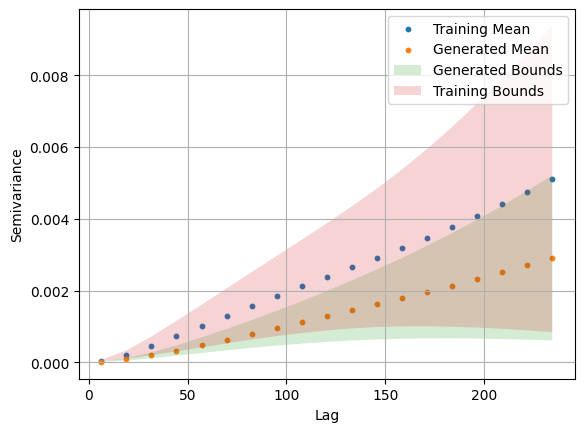

In [18]:
# Plot mean and bounds
plt.scatter(bin_center_training, mean_training, label='Training Mean', s=10)
plt.scatter(bin_center_generated, mean_generated, label='Generated Mean', s=10)

plt.fill_between(bin_center_generated, mean_generated - np.sqrt(variance_generated), mean_generated + np.sqrt(variance_generated), alpha=0.2, label='Generated Bounds')
plt.fill_between(bin_center_training, mean_training - np.sqrt(variance_training), mean_training + np.sqrt(variance_training), alpha=0.2, label='Training Bounds')

plt.xlabel('Lag')
plt.ylabel('Semivariance')
plt.legend()
plt.grid()
plt.show()

Plot periodogram mean and variance for VAE generated topographs and training data

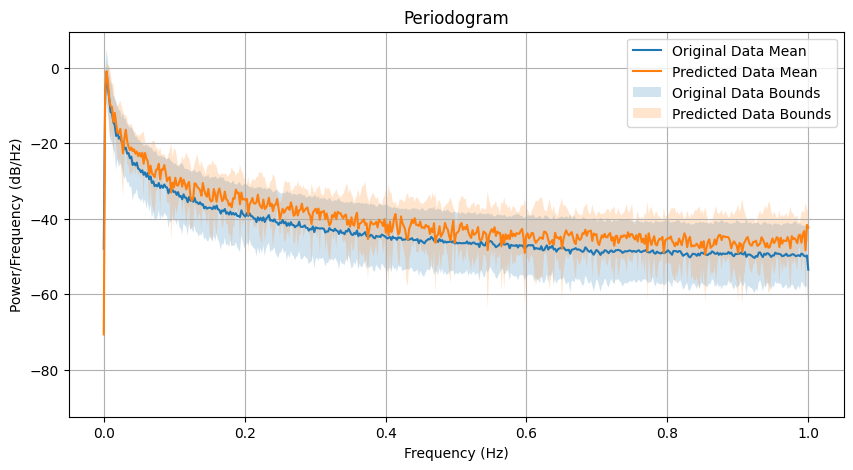

In [19]:
def generate_data(data):
    training_number = np.random.randint(0, data.shape[0] - 1)
    image_number = np.random.randint(0, new_images.shape[0] - 1)
    array1 = data[training_number].reshape(-1)
    array2 = new_images[image_number].reshape(-1)
    return array1, array2

# Number of datasets to generate
n_datasets = 100

# Lists to store periodograms for each dataset
all_periodograms_original = []
all_periodograms_predicted = []

# Generate n datasets and calculate periodograms
for _ in range(n_datasets):
    array1, array2 = generate_data(data)
    
    # Calculate periodogram using scipy.signal.periodogram
    freqs1, psd1 = periodogram(array1, fs=2, nfft=1024, window='hann')
    freqs2, psd2 = periodogram(array2, fs=2, nfft=1024, window='hann')
    
    all_periodograms_original.append(10 * np.log10(psd1))  # Convert to dB for better visualization
    all_periodograms_predicted.append(10 * np.log10(psd2))  # Convert to dB for better visualization

# Calculate mean and variance for original and predicted data
mean_original = np.mean(all_periodograms_original, axis=0)
variance_original = np.var(all_periodograms_original, axis=0)

mean_predicted = np.mean(all_periodograms_predicted, axis=0)
variance_predicted = np.var(all_periodograms_predicted, axis=0)

# Plot mean and bounds for periodogram
plt.figure(figsize=(10, 5))
plt.plot(freqs1, mean_original, label='Original Data Mean')
plt.plot(freqs2, mean_predicted, label='Predicted Data Mean')

plt.fill_between(freqs1, mean_original - np.sqrt(variance_original), mean_original + np.sqrt(variance_original), alpha=0.2, label='Original Data Bounds')
plt.fill_between(freqs2, mean_predicted - np.sqrt(variance_predicted), mean_predicted + np.sqrt(variance_predicted), alpha=0.2, label='Predicted Data Bounds')

plt.title('Periodogram')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power/Frequency (dB/Hz)')
plt.legend()
plt.grid(True)
plt.show()

The variogram suggests that most of the topographs generated by the VAE lie within the bounds of the training dataset. Although there does seem to be a bias. The periodogram is also similar to the training data but with a some noise addded at all frequencies. 